Notes:
- Both APIs could run in parallel on seperate threads to save time waiting for the call delay
- Fsqr ratings need to be halved to standardize with yelp
- POI_results folder in data should be renamed to query_results, and csvs from poi_\<API\> to query_\<API\>
- a decision matrix could be used to automate the Yelp vs Foursquare comparison

In [1]:
# import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

## Set-up

In [2]:
# set constants:
FOURSQUARE_API_KEY = os.getenv('FOURSQUARE_API_KEY')
YELP_API_KEY = os.getenv('YELP_API_KEY')
CALL_DELAY = 0.25 # pause (in s) after each call

In [3]:
# set notebook parameters:

# city data to load
city = 'Palma'

# yelp and foursquare query parameters
radius = '1000'
limit = '10'
sort = 'distance' #experimental

# Foursquare

In [4]:
# define Foursquare specific functions

# format lat and long for Foursquare API
def getLatLong(cityBikes_df):
    ll_list = []
    for station in cityBikes_df.index:
        ll_list.append('{},{}'.format(cityBikes_df.iloc[station]['latitude'], cityBikes_df.iloc[station]['longitude']))
    return ll_list


def getPOIs_FSQR(cityBikes_df):
    
    # initialize dataframe
    df = pd.DataFrame(columns = ['station_name', 'station_id', 'API', 'id', 'category', 'distance', 'name', 'rating', 'ratings'])
    
    # format latitude and longitude for Foursquare API
    cityBikes_df['ll'] = (pd.Series(getLatLong(CITY_BIKES)))
    
    for station in cityBikes_df.index:
        
        # make API call
        params = {
            'll': cityBikes_df.iloc[station]['ll'],
            'radius': radius,
            'categories': '13000', #Dining and Drinking
            'fields': ['categories', 'fsq_id', 'distance', 'name', 'rating', 'stats'],
            'sort': str.upper(sort),
            'limit': limit
        }
        
        url = f"https://api.foursquare.com/v3/places/search?ll={cityBikes_df.iloc[station]['ll']}&categories={params['categories']}&radius={params['radius']}&fields={params['fields'][0]}%2C{params['fields'][1]}%2C{params['fields'][2]}%2C{params['fields'][3]}%2C{params['fields'][4]}%2C{params['fields'][5]}&sort={params['sort']}&limit={params['limit']}"

        headers = {
            "Accept": "application/json",
            "Authorization": FOURSQUARE_API_KEY
        }

        response = requests.request("GET", url, headers=headers).json()
        time.sleep(CALL_DELAY)
        
        for POI in response['results']:
            
            # collecting category, distance, fsq_id, name, rating, ratings
            try:
                category = POI['categories'][0]['name']
            except:
                None
            distance = POI['distance']
            fsq_id = POI['fsq_id']
            name = POI['name']
            try:
                rating = POI['rating']
            except:
                rating = None
            try:
                ratings = POI['stats']['total_ratings']
            except:
                ratings = None
                
            # tag as FSQR
            API = "FSQR"
            
            # add station information
            station_name = cityBikes_df.iloc[station]['name']
            station_id = cityBikes_df.iloc[station]['station_id']
            
            # save to dataframe
            new_row = pd.Series({'station_name': station_name, 'station_id': station_id,
                       'API': API, 'id': fsq_id, 'category': category,
                       'distance': distance, 'name': name, 'rating': rating,
                       'ratings':ratings})
            df = pd.concat([df, new_row.to_frame().T], ignore_index=True)
        
    return df

# Yelp

In [5]:
#define yelp specific functions

def getPOIs_YELP(cityBikes_df): 

    # initialize dataframe
    df = pd.DataFrame(columns = ['station_name', 'station_id', 'API', 'id', 'category', 'distance', 'name', 'rating', 'ratings'])
    
    for station in cityBikes_df.index:
        
        # make API call
        params = {
            'latitude': cityBikes_df.iloc[station]['latitude'],
            'longitude': cityBikes_df.iloc[station]['longitude'],
            'radius': radius,
            'sort': sort,
            'limit': limit
        }
        url = (f"https://api.yelp.com/v3/businesses/search?latitude={params['latitude']}&longitude={params['longitude']}&radius={params['radius']}&sort_by={params['sort']}&limit={params['limit']}")
        
        headers = {
            "accept": "application/json",
            "Authorization": "bearer " + YELP_API_KEY
        }

        response = requests.get(url, headers=headers).json()
        time.sleep(CALL_DELAY)
                
        for POI in response['businesses']:
            
            # collect id, category, distance, name, rating, ratings
            yelp_id = POI['id']
            try:
                category = POI['categories'][0]['title']
            except:
                None
            distance = POI['distance']
            name = POI['name']
            rating = POI['rating']
            ratings = POI['review_count']
            
            # tag as Yelp
            API = "YELP"
            
            # add station information
            station_name = cityBikes_df.iloc[station]['name']
            station_id = cityBikes_df.iloc[station]['station_id']
            
            # save to dataframe
            new_row = pd.Series({'station_name': station_name, 'station_id': station_id,
                       'API': API, 'id': yelp_id, 'category': category,
                       'distance': distance, 'name': name, 'rating': rating,
                       'ratings':ratings})
            df = pd.concat([df, new_row.to_frame().T], ignore_index=True)
            
    return df

# Main

In [6]:
# load data
CITY_BIKES = pd.read_csv(f'../data/Networks/{city}Bikes.csv')

In [7]:
# query Foursquare
results_FSQR = getPOIs_FSQR(CITY_BIKES)

In [8]:
results_FSQR.head()

,station_name,station_id,API,id,category,distance,name,rating,ratings
0,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,FSQR,4e99f8f029c27d6ad668a7ca,Bar,212,Morrison Bar,None,None
1,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,FSQR,77d1e5be0ab5fcd4ec85c498,Pizzeria,276,Pizza Nostra Ciutat,None,None
2,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,FSQR,4f5e6a0ce4b0028cf960560b,Taco Restaurant,299,Chapultepec,9.0,77
3,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,FSQR,5048f886e4b0690ac775f082,Chinese Restaurant,306,Nong Jia Le,None,None
4,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,FSQR,4d3de317af8ca1436f0110f7,Asian Restaurant,331,Shi Shan Xuan,8.0,120


In [9]:
# query Yelp
results_YELP = getPOIs_YELP(CITY_BIKES)

In [10]:
results_YELP.head()

,station_name,station_id,API,id,category,distance,name,rating,ratings
0,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,YELP,BWWXOHCcfSNXl3yeGcErsw,Chinese,324.543739,Shi Shan Xuan,5.0,3
1,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,YELP,e3F0HeIfhCByxFN9hUP_cA,Bars,406.299598,Las Caribenas,5.0,1
2,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,YELP,8yYthxSx297ic_pIG5D3Lg,Tapas Bars,406.663624,Dehesa Santa Maria,4.0,1
3,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,YELP,4tGOSHJlKK2MXkwszcnbdQ,Bars,423.613087,Bar Monaco,4.0,1
4,F. MANUEL HERREROS,abb1d34b9bf558d40cd02e26ab1dc8b3,YELP,JqjGid2vEcHBvxSbL2Oi5w,Spanish,444.985865,Palacio Chino,5.0,1


In [11]:
# send query results to csv
results_FSQR.to_csv('../data/POI_results/pois_FSQR.csv', index = False)
results_YELP.to_csv('../data/POI_results/pois_YELP.csv', index = False)

# Comparing Results

The following analysis is conducted on results from notebook parameters\[city = 'Palma', radius = '1000', limit = '10', sort = 'distance'\] and Foursquare category set to 'Dining and Drinking'.

Q: Which API provided you with more complete data? Provide an explanation. 

A: Yelp API provides more complete data, because the API specifies in the documentation that it will not return results without ratings. Run the code cell below for details:

In [12]:
print("Information on nulls - Foursquare:")
print(results_FSQR.info())
print("\n{} foursquare results do not have ratings".format(results_FSQR['rating'].isna().sum()))
print("\nInformation on nulls - Yelp:")
print(results_YELP.info())
print("\n{} yelp results do not have ratings".format(results_YELP['rating'].isna().sum()))

Information on nulls - Foursquare:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   station_name  370 non-null    object
 1   station_id    370 non-null    object
 2   API           370 non-null    object
 3   id            370 non-null    object
 4   category      370 non-null    object
 5   distance      370 non-null    object
 6   name          370 non-null    object
 7   rating        216 non-null    object
 8   ratings       216 non-null    object
dtypes: object(9)
memory usage: 26.1+ KB
None

154 foursquare results do not have ratings

Information on nulls - Yelp:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   station_name  370 non-null    object
 1   station_id    370 non-null    object
 2   AP

Yelp has no null values, while foursquare is missing ratings for some of its returned results. It is important to note that this is not the same as number of ratings missing per unique result, or number of overall average ratings, so I will explore these and some other important metrics for quality:

In [13]:
fsqr_unique = len(pd.unique(results_FSQR['id']))
print(f"Foursquare produced {fsqr_unique} unique results")
yelp_unique = len(pd.unique(results_YELP['id']))
print(f"Yelp produced {yelp_unique} unique results")

Foursquare produced 214 unique results
Yelp produced 205 unique results


#### Ratings per bike station

Foursquare provided 13556 ratings over 37 bike stations for an average of 366 ratings per station
Yelp provided 1014 ratings over 37 bike stations for an average of 27 ratings per station


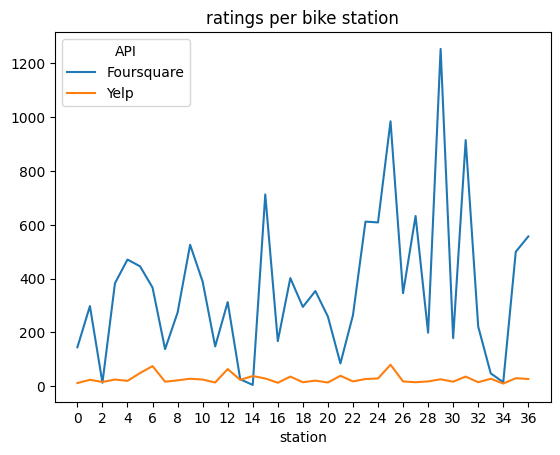

In [14]:
fsqr_sumRatings = results_FSQR['ratings'].sum()
yelp_sumRatings = results_YELP['ratings'].sum()
print(f'Foursquare provided {fsqr_sumRatings} ratings over {len(CITY_BIKES)} bike stations for an average of {round(fsqr_sumRatings / len(CITY_BIKES))} ratings per station')
print(f'Yelp provided {yelp_sumRatings} ratings over {len(CITY_BIKES)} bike stations for an average of {round(yelp_sumRatings / len(CITY_BIKES))} ratings per station')

# create comparison lineplot
fsqr_sums_df = results_FSQR[['API', 'station_name', 'ratings']].groupby('station_name').sum()
yelp_sums_df = results_YELP[['API', 'station_name', 'ratings']].groupby('station_name').sum()

plt.plot(range(len(fsqr_sums_df)), (fsqr_sums_df['ratings']))
plt.plot(range(len(yelp_sums_df)), (yelp_sums_df['ratings']))
plt.title('ratings per bike station')
plt.xlabel('station')
plt.xticks((range(len(fsqr_sums_df)))[::2])
plt.legend(title='API', loc='upper left', labels=['Foursquare', 'Yelp'])
plt.savefig(f'../images/ratingsPerBikeStation{city}.png')

In the city of Palma, Foursquare's total ratings beat Yelp's ratings at a ratio of almost 14:1. Based on the similarity of unique results returned and the overwhelmingly higher amount of average ratings, I would suggest the use of Foursquare for querying 'Dining and Drinking' data in Palma. Further, since Yelp is a service specializing in 'Dining and Drinking' data, I would suggest using Foursquare for all categories of place of interest queries in Palma.